In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
%cd /content/drive/MyDrive/Universidad/Aprendizaje Automático II/Práctica/Trabajos/FINAL/IMAGENES

/content/drive/MyDrive/AA II/NUEVO (1)


In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Definir transformaciones para los datos de entrenamiento y validación
transformaciones = transforms.Compose([
    transforms.Resize((100, 100)),  # Redimensionar las imágenes
    transforms.ToTensor()  # Convertir las imágenes a tensores
])

# Cargar los datos de entrenamiento y validación
dataset_entrenamiento = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/train', transform=transformaciones)
dataset_validacion = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/validation', transform=transformaciones)
dataset_test = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/test', transform=transformaciones)

In [2]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Nueva capa convolucional

        # Batch Normalization para cada capa convolucional
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=128)  # Normalización para la nueva capa

        # MaxPooling y Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout_conv = nn.Dropout(p=0.25)  # Dropout para capas convolucionales
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout para capas densas

        # Capas completamente conectadas
        self.fc1 = nn.Linear(128 * 6 * 6, 256)  # Ajuste del tamaño según salida de la última capa convolucional
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)  # Salida para 7 clases

        # Batch Normalization para capas densas
        self.fc_bn1 = nn.BatchNorm1d(256)
        self.fc_bn2 = nn.BatchNorm1d(128)

    def forward(self, x):
        # Pasos convolucionales con activación, normalización y pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Nueva capa convolucional
        x = self.dropout_conv(x)

        # Aplanar para pasar a capas densas
        x = x.view(-1, 128 * 6 * 6)

        # Pasos densos con activación, normalización y dropout
        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = self.dropout_fc(x)

        x = F.relu(self.fc_bn2(self.fc2(x)))
        x = self.dropout_fc(x)

        x = self.fc3(x)  # Sin activación final porque CrossEntropyLoss la incluye
        return x


In [4]:
def graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion):
    # Crear una figura con dos subgráficos en una fila
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Graficar la función de pérdida en el primer subgráfico
    ax[0].plot(valores_perdida, label='Pérdida')
    ax[0].set_xlabel('Épocas')
    ax[0].set_ylabel('Pérdida')
    ax[0].set_title(f'Función de Pérdida\n LR: {lr} Batch Size: {batch_size}')
    ax[0].legend()

    # Graficar las exactitudes en el segundo subgráfico
    ax[1].plot(exactitud_entrenamiento, label='Exactitud de Entrenamiento')
    ax[1].plot(exactitud_validacion, label='Exactitud de Validación')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Exactitud')
    ax[1].set_title(f'Exactitud de Entrenamiento y Validación\n LR: {lr} Batch Size: {batch_size}')
    ax[1].legend()

    # Ajustar espaciado entre los gráficos
    plt.tight_layout()

    # Mostrar los gráficos
    plt.show()

In [5]:
def calcular_exactitud_test(modelo, dataloader_test, device):
    correctas = 0
    total = 0
    with torch.no_grad():
        modelo.eval()

        for images, labels in dataloader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = modelo(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correctas += (predicted == labels).sum().item()
        #print(f'Exactitud de el modelo con las {total} imágenes de test: {100*correctas/total}%')
    return 100*correctas/total

In [6]:
def matriz_de_confusion(modelo, dataloader_test, device):

    modelo.eval()

    # Inicializar listas para etiquetas reales y predicciones
    predicciones_totales = []
    etiquetas_reales_totales = []

    # Verificar que el dataloader_test tiene datos
    if len(dataloader_test.dataset) == 0:
        print("El conjunto de test está vacío. Verifica los datos.")
    else:
        # Bucle para obtener predicciones
        with torch.no_grad():
            for imagenes, etiquetas in dataloader_test:
                imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
                salidas = modelo(imagenes)
                _, predicciones = torch.max(salidas, 1)
                predicciones_totales.extend(predicciones.cpu().numpy())
                etiquetas_reales_totales.extend(etiquetas.cpu().numpy())

    # Comprobar si se obtuvieron predicciones
    if len(etiquetas_reales_totales) > 0 and len(predicciones_totales) > 0:
        # Imprimir el reporte de clasificación
        print("Reporte de clasificación:")
        print(classification_report(etiquetas_reales_totales, predicciones_totales, digits=4))

        # Crear la matriz de confusión
        etiquetas_unicas = sorted(set(etiquetas_reales_totales))  # Identificar las clases presentes
        matriz_confusion_test = confusion_matrix(etiquetas_reales_totales, predicciones_totales, labels=etiquetas_unicas)

        # Visualizar la matriz de confusión
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusion_test, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_unicas, yticklabels=etiquetas_unicas)
        plt.xlabel('Predicciones')
        plt.ylabel('Etiquetas Reales')
        plt.title('Matriz de Confusión del Conjunto de Test')
        plt.show()

        # Mostrar las clases presentes
        clases_presentes = set(etiquetas_reales_totales)
        print(f"Clases presentes en el conjunto de test: {clases_presentes}")
    else:
        print("No se encontraron datos válidos para generar predicciones o etiquetas.")


Entrenando con lr=0.005, batch_size=32, epochs=15
    Época 1, pérdida: 1.5470, exactitud entrenamiento: 25.20%, exactitud validación: 24.86%
    Época 2, pérdida: 1.2407, exactitud entrenamiento: 64.76%, exactitud validación: 61.38%
    Época 3, pérdida: 1.0597, exactitud entrenamiento: 58.96%, exactitud validación: 55.87%
    Época 4, pérdida: 0.9379, exactitud entrenamiento: 74.03%, exactitud validación: 70.00%
    Época 5, pérdida: 0.8512, exactitud entrenamiento: 68.08%, exactitud validación: 64.95%
    Época 6, pérdida: 0.7380, exactitud entrenamiento: 83.86%, exactitud validación: 78.44%
    Época 7, pérdida: 0.7158, exactitud entrenamiento: 73.35%, exactitud validación: 70.00%
    Época 8, pérdida: 0.6491, exactitud entrenamiento: 84.47%, exactitud validación: 77.89%
    Época 9, pérdida: 0.5410, exactitud entrenamiento: 69.07%, exactitud validación: 63.76%
    Época 10, pérdida: 0.5281, exactitud entrenamiento: 92.58%, exactitud validación: 84.31%
    Época 11, pérdida: 0.455

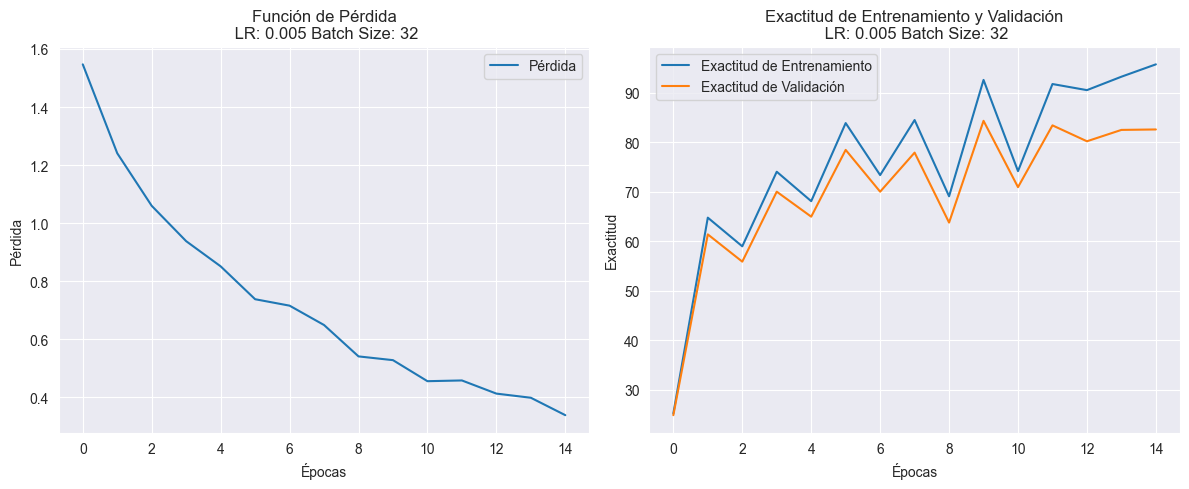


Entrenando con lr=0.005, batch_size=32, epochs=30
    Época 1, pérdida: 1.6213, exactitud entrenamiento: 42.21%, exactitud validación: 42.02%
    Época 2, pérdida: 1.2907, exactitud entrenamiento: 56.53%, exactitud validación: 52.29%
    Época 3, pérdida: 1.0919, exactitud entrenamiento: 60.14%, exactitud validación: 58.90%
    Época 4, pérdida: 0.9653, exactitud entrenamiento: 74.09%, exactitud validación: 71.56%
    Época 5, pérdida: 0.8641, exactitud entrenamiento: 75.32%, exactitud validación: 72.39%
    Época 6, pérdida: 0.7702, exactitud entrenamiento: 73.48%, exactitud validación: 67.71%
    Época 7, pérdida: 0.6978, exactitud entrenamiento: 84.23%, exactitud validación: 76.06%
    Época 8, pérdida: 0.6652, exactitud entrenamiento: 75.79%, exactitud validación: 71.65%
    Época 9, pérdida: 0.5863, exactitud entrenamiento: 88.76%, exactitud validación: 80.83%
    Época 10, pérdida: 0.5675, exactitud entrenamiento: 89.25%, exactitud validación: 80.46%
    Época 11, pérdida: 0.522

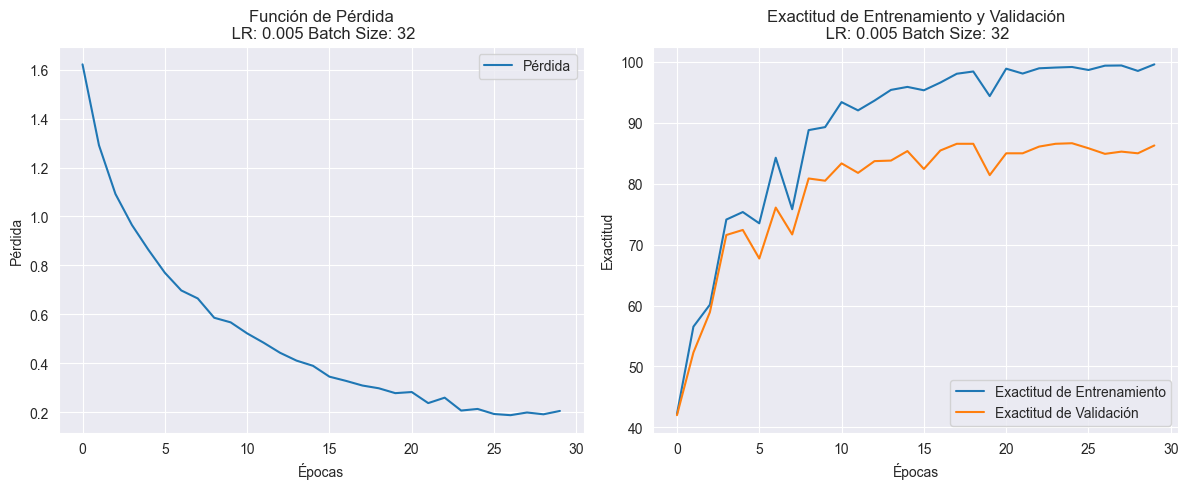


Entrenando con lr=0.005, batch_size=64, epochs=15
    Época 1, pérdida: 1.5579, exactitud entrenamiento: 34.60%, exactitud validación: 34.22%
    Época 2, pérdida: 1.1502, exactitud entrenamiento: 46.18%, exactitud validación: 45.23%
    Época 3, pérdida: 1.0395, exactitud entrenamiento: 62.05%, exactitud validación: 59.45%
    Época 4, pérdida: 0.8385, exactitud entrenamiento: 77.97%, exactitud validación: 73.30%
    Época 5, pérdida: 0.7585, exactitud entrenamiento: 80.50%, exactitud validación: 73.67%
    Época 6, pérdida: 0.6756, exactitud entrenamiento: 60.87%, exactitud validación: 57.34%
    Época 7, pérdida: 0.5921, exactitud entrenamiento: 84.53%, exactitud validación: 77.52%
    Época 8, pérdida: 0.5806, exactitud entrenamiento: 74.98%, exactitud validación: 68.99%
    Época 9, pérdida: 0.5121, exactitud entrenamiento: 77.36%, exactitud validación: 70.64%
    Época 10, pérdida: 0.4870, exactitud entrenamiento: 87.65%, exactitud validación: 77.98%
    Época 11, pérdida: 0.410

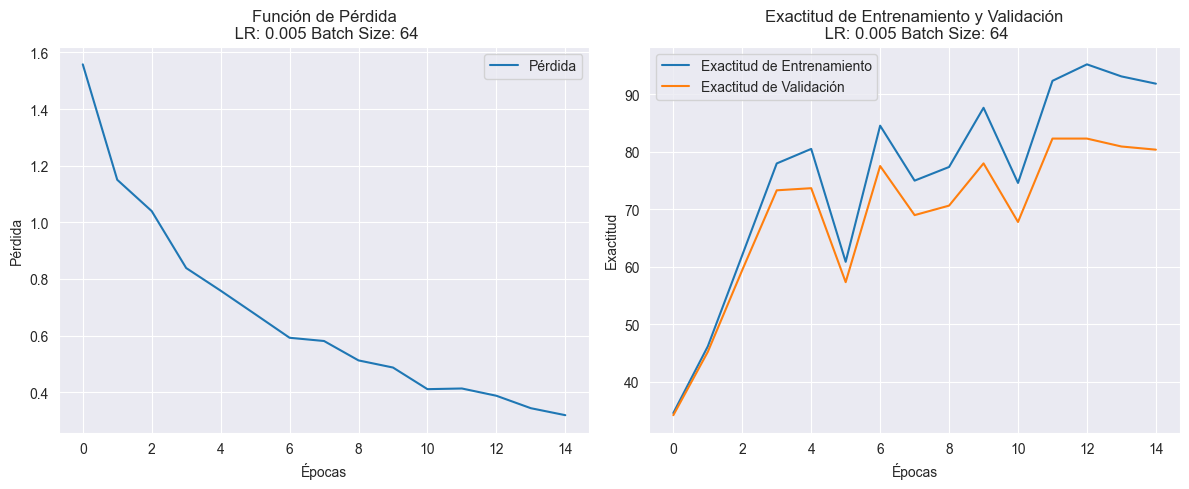


Entrenando con lr=0.005, batch_size=64, epochs=30
    Época 1, pérdida: 1.5332, exactitud entrenamiento: 59.30%, exactitud validación: 58.17%
    Época 2, pérdida: 1.1418, exactitud entrenamiento: 64.57%, exactitud validación: 61.38%
    Época 3, pérdida: 1.0122, exactitud entrenamiento: 46.64%, exactitud validación: 46.24%
    Época 4, pérdida: 0.8640, exactitud entrenamiento: 73.07%, exactitud validación: 66.61%
    Época 5, pérdida: 0.7312, exactitud entrenamiento: 78.68%, exactitud validación: 71.01%
    Época 6, pérdida: 0.6752, exactitud entrenamiento: 74.25%, exactitud validación: 67.43%
    Época 7, pérdida: 0.6170, exactitud entrenamiento: 85.95%, exactitud validación: 77.80%
    Época 8, pérdida: 0.5685, exactitud entrenamiento: 80.47%, exactitud validación: 72.84%
    Época 9, pérdida: 0.4882, exactitud entrenamiento: 84.69%, exactitud validación: 74.59%
    Época 10, pérdida: 0.4350, exactitud entrenamiento: 86.20%, exactitud validación: 74.31%
    Época 11, pérdida: 0.396

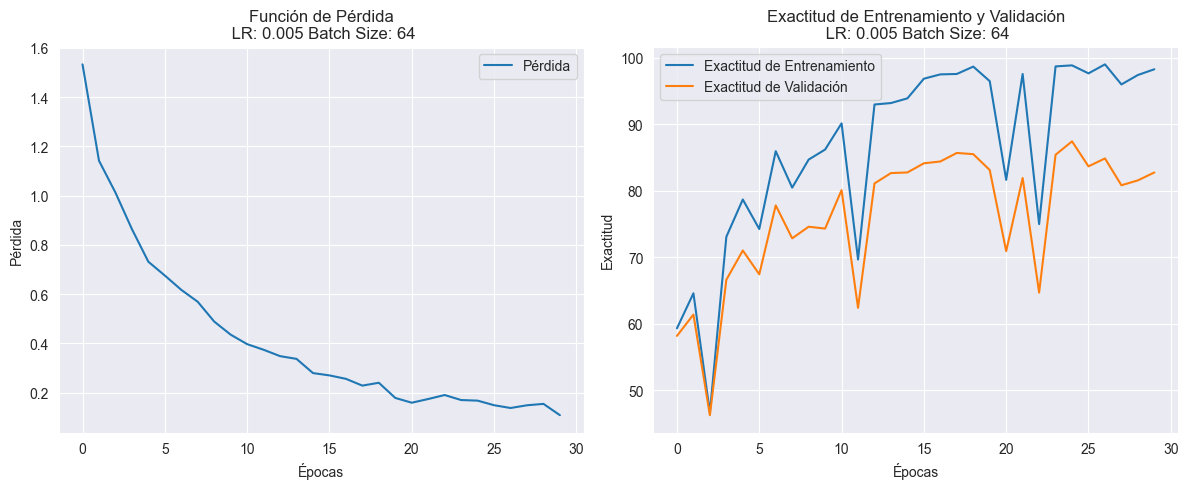


Entrenando con lr=0.001, batch_size=32, epochs=15
    Época 1, pérdida: 1.4958, exactitud entrenamiento: 41.07%, exactitud validación: 39.17%
    Época 2, pérdida: 1.0889, exactitud entrenamiento: 53.91%, exactitud validación: 52.48%
    Época 3, pérdida: 0.9065, exactitud entrenamiento: 60.26%, exactitud validación: 57.25%
    Época 4, pérdida: 0.7675, exactitud entrenamiento: 67.81%, exactitud validación: 63.21%
    Época 5, pérdida: 0.7186, exactitud entrenamiento: 37.58%, exactitud validación: 36.15%
    Época 6, pérdida: 0.6529, exactitud entrenamiento: 87.74%, exactitud validación: 81.38%
    Época 7, pérdida: 0.5902, exactitud entrenamiento: 69.90%, exactitud validación: 66.15%
    Época 8, pérdida: 0.5372, exactitud entrenamiento: 87.18%, exactitud validación: 78.62%
    Época 9, pérdida: 0.4862, exactitud entrenamiento: 88.54%, exactitud validación: 80.73%
    Época 10, pérdida: 0.4616, exactitud entrenamiento: 93.16%, exactitud validación: 84.95%
    Época 11, pérdida: 0.431

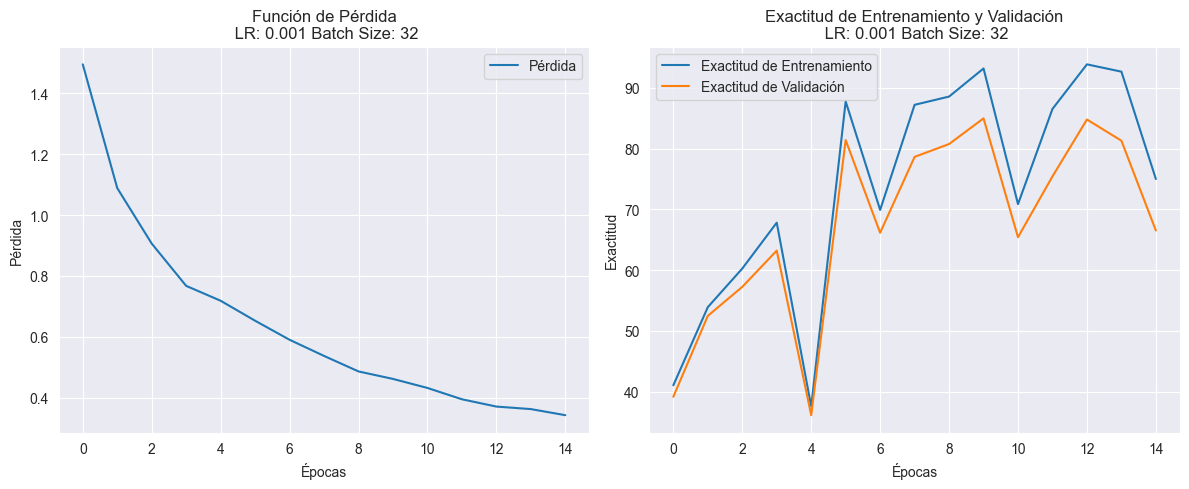


Entrenando con lr=0.001, batch_size=32, epochs=30
    Época 1, pérdida: 1.5176, exactitud entrenamiento: 30.75%, exactitud validación: 28.17%
    Época 2, pérdida: 1.1294, exactitud entrenamiento: 69.22%, exactitud validación: 67.52%
    Época 3, pérdida: 0.9586, exactitud entrenamiento: 65.90%, exactitud validación: 64.40%
    Época 4, pérdida: 0.8538, exactitud entrenamiento: 78.71%, exactitud validación: 73.67%
    Época 5, pérdida: 0.7579, exactitud entrenamiento: 80.41%, exactitud validación: 75.50%
    Época 6, pérdida: 0.6631, exactitud entrenamiento: 85.55%, exactitud validación: 79.08%
    Época 7, pérdida: 0.5822, exactitud entrenamiento: 73.69%, exactitud validación: 68.17%
    Época 8, pérdida: 0.5510, exactitud entrenamiento: 78.93%, exactitud validación: 73.94%
    Época 9, pérdida: 0.5333, exactitud entrenamiento: 89.31%, exactitud validación: 81.10%
    Época 10, pérdida: 0.4419, exactitud entrenamiento: 92.82%, exactitud validación: 84.77%
    Época 11, pérdida: 0.418

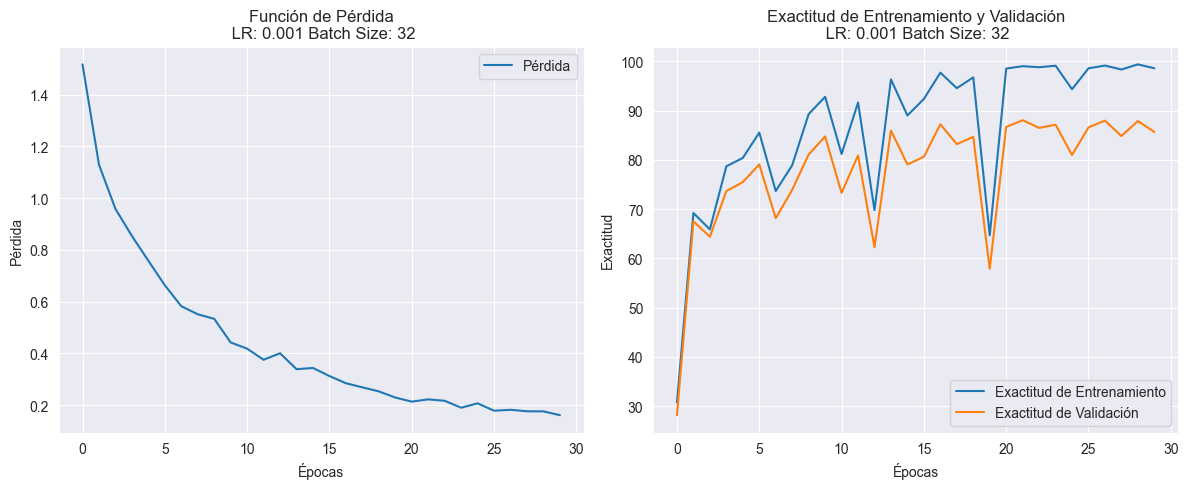


Entrenando con lr=0.001, batch_size=64, epochs=15
    Época 1, pérdida: 1.5246, exactitud entrenamiento: 29.76%, exactitud validación: 27.25%
    Época 2, pérdida: 1.1117, exactitud entrenamiento: 38.05%, exactitud validación: 36.51%
    Época 3, pérdida: 0.9513, exactitud entrenamiento: 56.53%, exactitud validación: 54.50%
    Época 4, pérdida: 0.8031, exactitud entrenamiento: 79.61%, exactitud validación: 73.67%
    Época 5, pérdida: 0.7095, exactitud entrenamiento: 79.48%, exactitud validación: 76.15%
    Época 6, pérdida: 0.6521, exactitud entrenamiento: 67.07%, exactitud validación: 62.48%
    Época 7, pérdida: 0.5886, exactitud entrenamiento: 84.07%, exactitud validación: 78.35%
    Época 8, pérdida: 0.5250, exactitud entrenamiento: 81.70%, exactitud validación: 74.77%
    Época 9, pérdida: 0.4765, exactitud entrenamiento: 76.40%, exactitud validación: 70.28%
    Época 10, pérdida: 0.4614, exactitud entrenamiento: 63.09%, exactitud validación: 58.17%
    Época 11, pérdida: 0.399

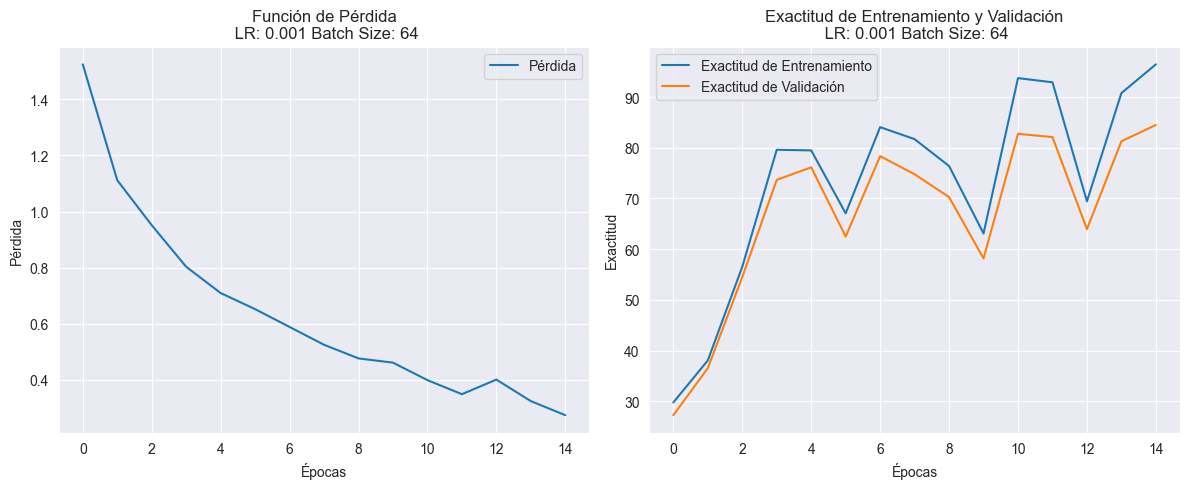


Entrenando con lr=0.001, batch_size=64, epochs=30
    Época 1, pérdida: 1.5860, exactitud entrenamiento: 20.18%, exactitud validación: 20.09%
    Época 2, pérdida: 1.1768, exactitud entrenamiento: 66.82%, exactitud validación: 63.58%
    Época 3, pérdida: 0.9760, exactitud entrenamiento: 63.59%, exactitud validación: 60.09%
    Época 4, pérdida: 0.8582, exactitud entrenamiento: 60.29%, exactitud validación: 58.35%
    Época 5, pérdida: 0.7734, exactitud entrenamiento: 71.66%, exactitud validación: 65.60%
    Época 6, pérdida: 0.6589, exactitud entrenamiento: 81.18%, exactitud validación: 74.31%
    Época 7, pérdida: 0.5927, exactitud entrenamiento: 75.69%, exactitud validación: 69.82%
    Época 8, pérdida: 0.5303, exactitud entrenamiento: 81.92%, exactitud validación: 75.78%
    Época 9, pérdida: 0.5134, exactitud entrenamiento: 77.97%, exactitud validación: 74.40%
    Época 10, pérdida: 0.4721, exactitud entrenamiento: 87.18%, exactitud validación: 76.79%
    Época 11, pérdida: 0.438

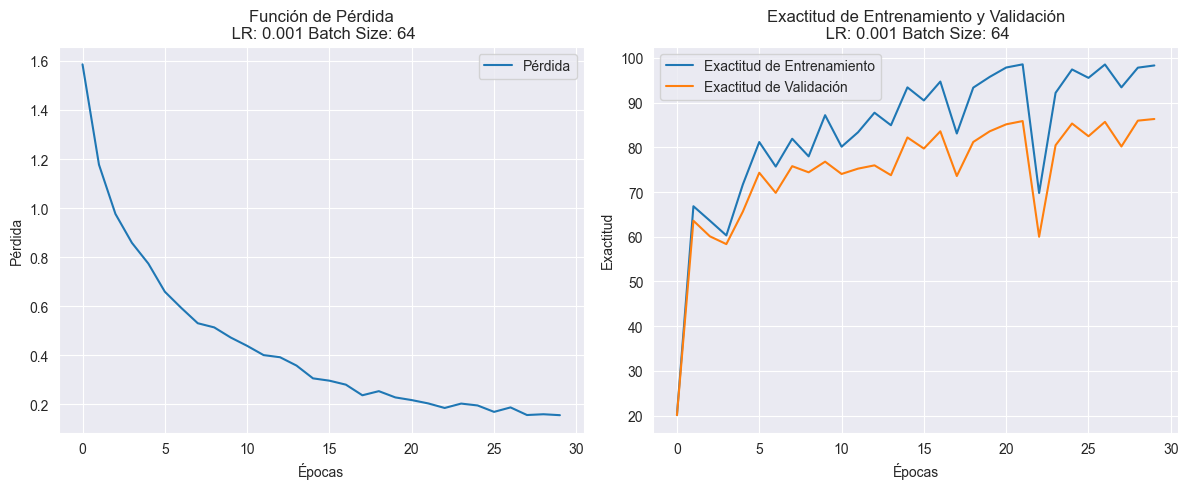


Entrenando con lr=0.0005, batch_size=32, epochs=15
    Época 1, pérdida: 1.5892, exactitud entrenamiento: 19.72%, exactitud validación: 20.37%
    Época 2, pérdida: 1.2379, exactitud entrenamiento: 31.48%, exactitud validación: 30.09%
    Época 3, pérdida: 1.0403, exactitud entrenamiento: 59.46%, exactitud validación: 57.06%
    Época 4, pérdida: 0.9238, exactitud entrenamiento: 66.88%, exactitud validación: 63.58%
    Época 5, pérdida: 0.8234, exactitud entrenamiento: 68.95%, exactitud validación: 64.59%
    Época 6, pérdida: 0.7444, exactitud entrenamiento: 78.71%, exactitud validación: 73.30%
    Época 7, pérdida: 0.6875, exactitud entrenamiento: 73.54%, exactitud validación: 68.99%
    Época 8, pérdida: 0.6303, exactitud entrenamiento: 81.12%, exactitud validación: 74.31%
    Época 9, pérdida: 0.5851, exactitud entrenamiento: 86.04%, exactitud validación: 77.80%
    Época 10, pérdida: 0.5379, exactitud entrenamiento: 88.94%, exactitud validación: 80.46%
    Época 11, pérdida: 0.48

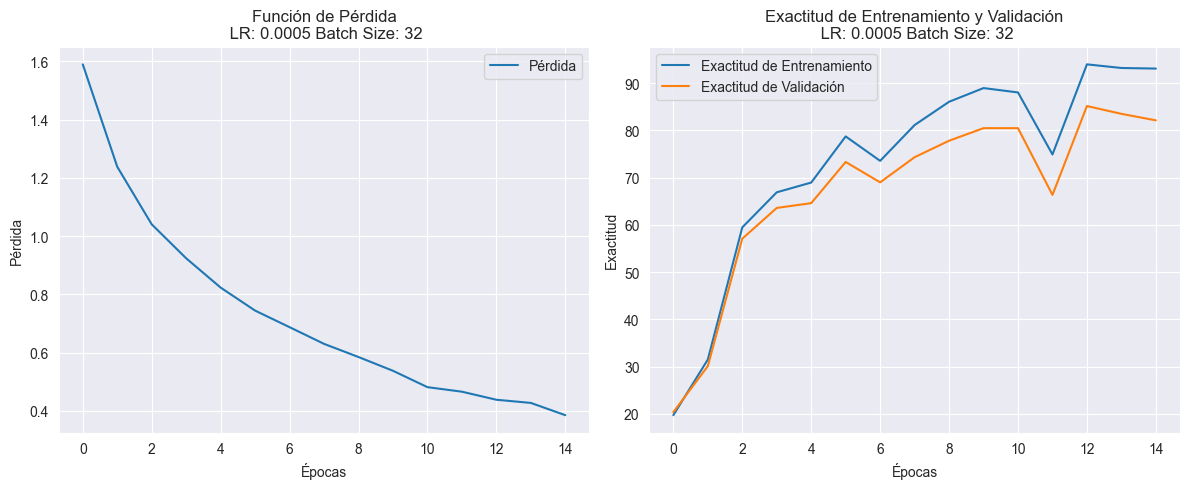


Entrenando con lr=0.0005, batch_size=32, epochs=30
    Época 1, pérdida: 1.5870, exactitud entrenamiento: 34.75%, exactitud validación: 33.21%
    Época 2, pérdida: 1.2069, exactitud entrenamiento: 43.72%, exactitud validación: 42.20%
    Época 3, pérdida: 1.0077, exactitud entrenamiento: 39.71%, exactitud validación: 39.17%
    Época 4, pérdida: 0.8742, exactitud entrenamiento: 68.82%, exactitud validación: 67.25%
    Época 5, pérdida: 0.7764, exactitud entrenamiento: 75.08%, exactitud validación: 71.10%
    Época 6, pérdida: 0.7162, exactitud entrenamiento: 76.03%, exactitud validación: 73.12%
    Época 7, pérdida: 0.6304, exactitud entrenamiento: 79.05%, exactitud validación: 74.86%
    Época 8, pérdida: 0.5860, exactitud entrenamiento: 70.79%, exactitud validación: 64.68%
    Época 9, pérdida: 0.5605, exactitud entrenamiento: 88.85%, exactitud validación: 81.83%
    Época 10, pérdida: 0.4986, exactitud entrenamiento: 79.64%, exactitud validación: 73.49%
    Época 11, pérdida: 0.46

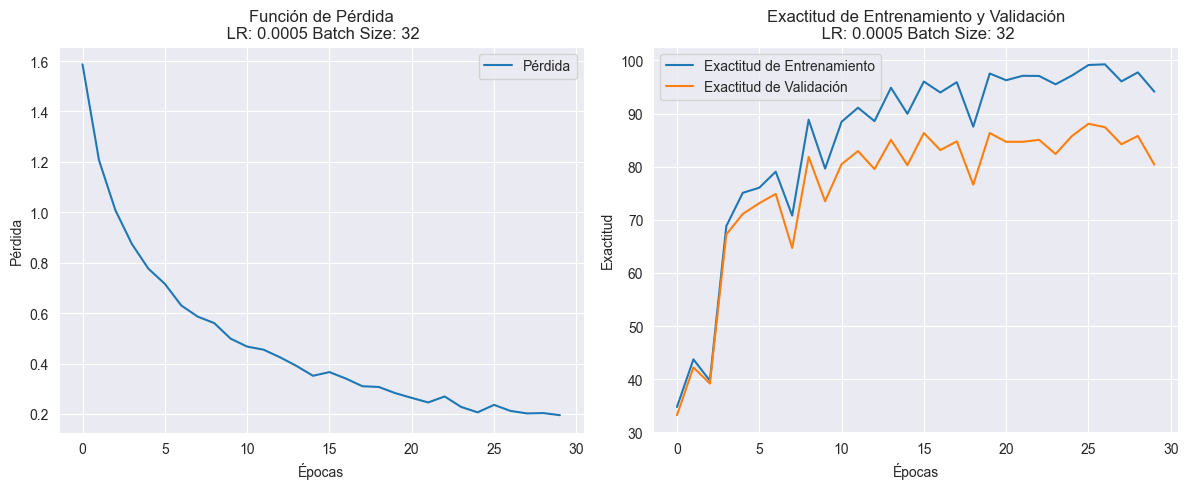


Entrenando con lr=0.0005, batch_size=64, epochs=15
    Época 1, pérdida: 1.6674, exactitud entrenamiento: 13.99%, exactitud validación: 13.94%
    Época 2, pérdida: 1.2915, exactitud entrenamiento: 29.05%, exactitud validación: 28.07%
    Época 3, pérdida: 1.0799, exactitud entrenamiento: 56.01%, exactitud validación: 53.03%
    Época 4, pérdida: 0.9582, exactitud entrenamiento: 62.14%, exactitud validación: 59.45%
    Época 5, pérdida: 0.8294, exactitud entrenamiento: 49.17%, exactitud validación: 46.33%
    Época 6, pérdida: 0.7601, exactitud entrenamiento: 71.63%, exactitud validación: 68.99%
    Época 7, pérdida: 0.7199, exactitud entrenamiento: 74.34%, exactitud validación: 71.56%
    Época 8, pérdida: 0.6298, exactitud entrenamiento: 79.11%, exactitud validación: 73.94%
    Época 9, pérdida: 0.5991, exactitud entrenamiento: 80.62%, exactitud validación: 75.69%
    Época 10, pérdida: 0.5386, exactitud entrenamiento: 86.75%, exactitud validación: 81.01%
    Época 11, pérdida: 0.51

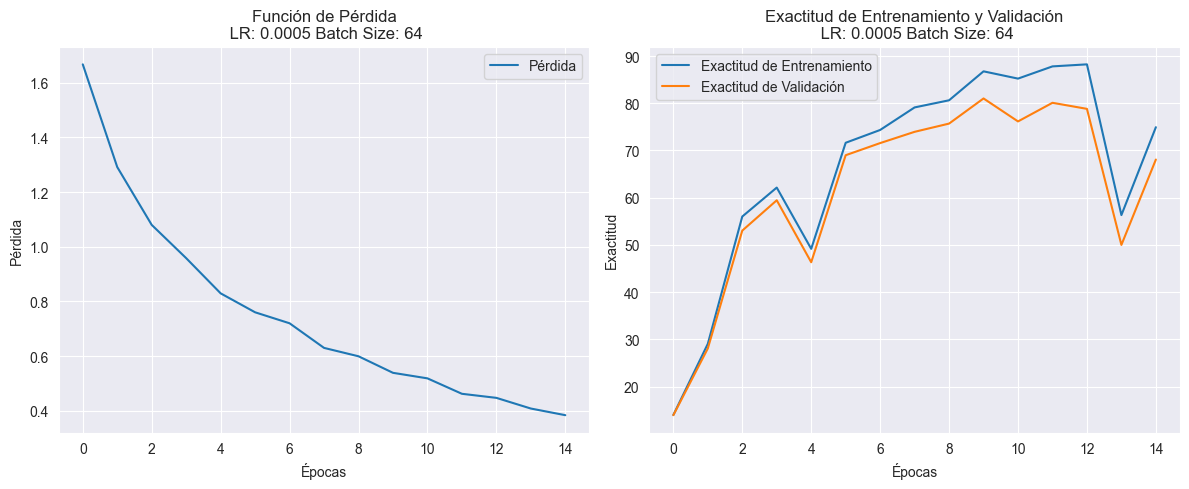


Entrenando con lr=0.0005, batch_size=64, epochs=30
    Época 1, pérdida: 1.6664, exactitud entrenamiento: 16.91%, exactitud validación: 16.88%
    Época 2, pérdida: 1.3016, exactitud entrenamiento: 32.29%, exactitud validación: 30.00%
    Época 3, pérdida: 1.0908, exactitud entrenamiento: 49.04%, exactitud validación: 46.42%
    Época 4, pérdida: 0.9552, exactitud entrenamiento: 57.36%, exactitud validación: 56.70%
    Época 5, pérdida: 0.8398, exactitud entrenamiento: 75.54%, exactitud validación: 72.75%
    Época 6, pérdida: 0.7303, exactitud entrenamiento: 73.04%, exactitud validación: 70.28%
    Época 7, pérdida: 0.6678, exactitud entrenamiento: 79.67%, exactitud validación: 75.50%
    Época 8, pérdida: 0.6115, exactitud entrenamiento: 84.97%, exactitud validación: 78.90%
    Época 9, pérdida: 0.5612, exactitud entrenamiento: 86.41%, exactitud validación: 78.07%
    Época 10, pérdida: 0.5295, exactitud entrenamiento: 79.98%, exactitud validación: 72.94%
    Época 11, pérdida: 0.50

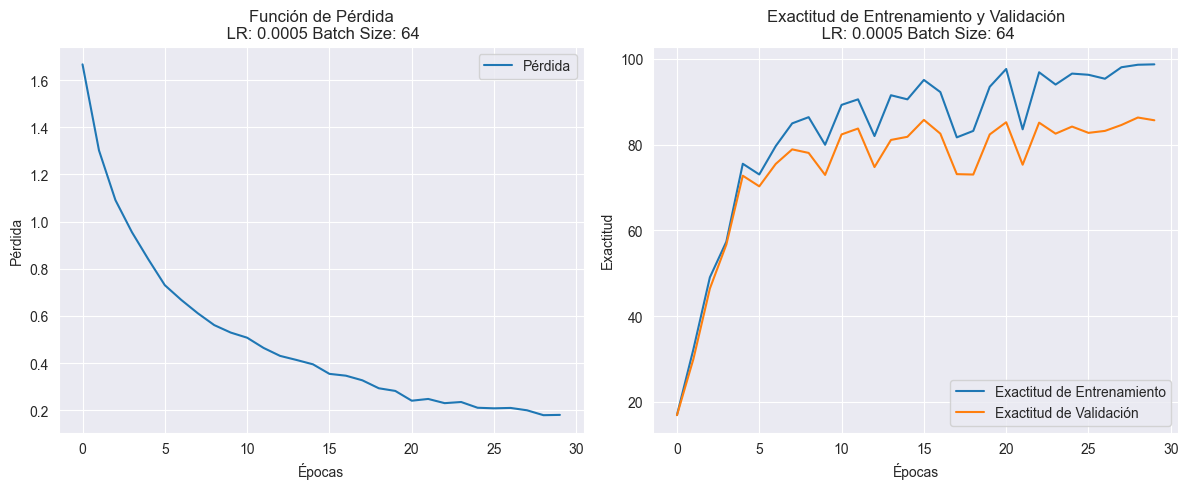


Entrenando con lr=0.0001, batch_size=32, epochs=15
    Época 1, pérdida: 1.8808, exactitud entrenamiento: 18.55%, exactitud validación: 18.17%
    Época 2, pérdida: 1.6249, exactitud entrenamiento: 24.61%, exactitud validación: 25.32%
    Época 3, pérdida: 1.4828, exactitud entrenamiento: 32.96%, exactitud validación: 34.31%
    Época 4, pérdida: 1.3727, exactitud entrenamiento: 42.21%, exactitud validación: 41.74%
    Época 5, pérdida: 1.2886, exactitud entrenamiento: 39.37%, exactitud validación: 38.81%
    Época 6, pérdida: 1.2103, exactitud entrenamiento: 45.59%, exactitud validación: 44.40%
    Época 7, pérdida: 1.1429, exactitud entrenamiento: 47.35%, exactitud validación: 46.97%
    Época 8, pérdida: 1.0681, exactitud entrenamiento: 61.12%, exactitud validación: 58.44%
    Época 9, pérdida: 1.0086, exactitud entrenamiento: 61.18%, exactitud validación: 58.07%
    Época 10, pérdida: 0.9525, exactitud entrenamiento: 61.61%, exactitud validación: 59.45%
    Época 11, pérdida: 0.90

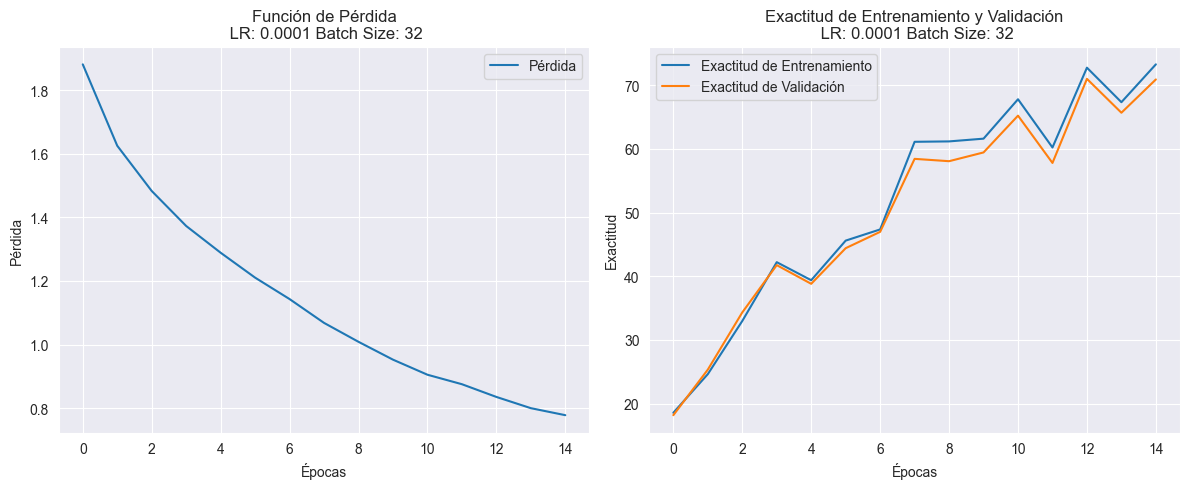


Entrenando con lr=0.0001, batch_size=32, epochs=30
    Época 1, pérdida: 1.8469, exactitud entrenamiento: 17.31%, exactitud validación: 16.42%
    Época 2, pérdida: 1.6055, exactitud entrenamiento: 28.74%, exactitud validación: 28.72%
    Época 3, pérdida: 1.4560, exactitud entrenamiento: 33.30%, exactitud validación: 32.39%
    Época 4, pérdida: 1.3449, exactitud entrenamiento: 47.94%, exactitud validación: 44.31%
    Época 5, pérdida: 1.2346, exactitud entrenamiento: 57.73%, exactitud validación: 54.86%
    Época 6, pérdida: 1.1502, exactitud entrenamiento: 58.53%, exactitud validación: 54.31%
    Época 7, pérdida: 1.0702, exactitud entrenamiento: 63.43%, exactitud validación: 61.01%
    Época 8, pérdida: 1.0088, exactitud entrenamiento: 61.18%, exactitud validación: 58.17%
    Época 9, pérdida: 0.9475, exactitud entrenamiento: 42.02%, exactitud validación: 40.83%
    Época 10, pérdida: 0.8838, exactitud entrenamiento: 59.52%, exactitud validación: 56.15%
    Época 11, pérdida: 0.82

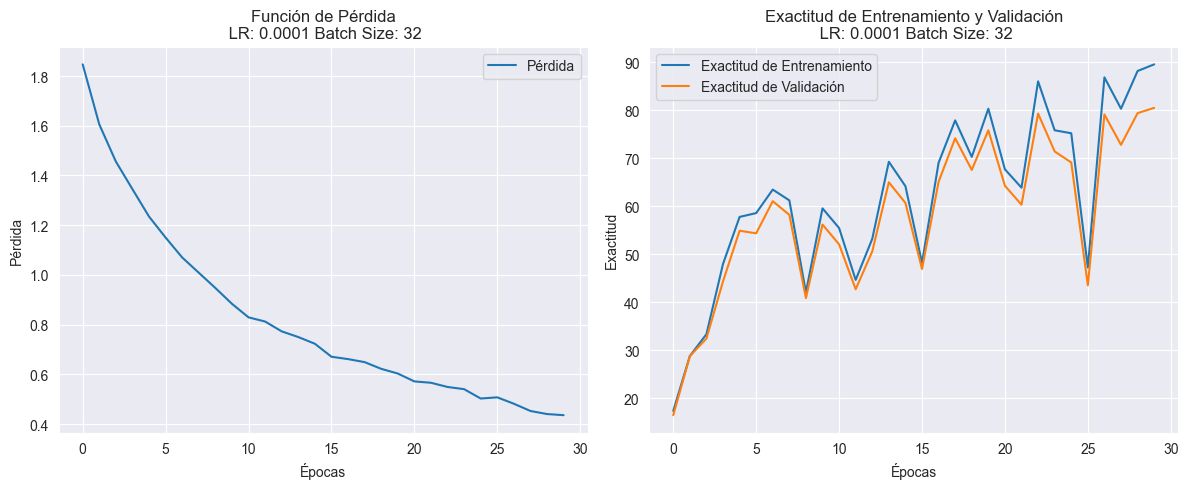


Entrenando con lr=0.0001, batch_size=64, epochs=15
    Época 1, pérdida: 1.8868, exactitud entrenamiento: 14.26%, exactitud validación: 14.22%
    Época 2, pérdida: 1.6790, exactitud entrenamiento: 20.52%, exactitud validación: 20.55%
    Época 3, pérdida: 1.5328, exactitud entrenamiento: 28.34%, exactitud validación: 28.07%
    Época 4, pérdida: 1.4261, exactitud entrenamiento: 26.52%, exactitud validación: 25.96%
    Época 5, pérdida: 1.3346, exactitud entrenamiento: 33.83%, exactitud validación: 33.85%
    Época 6, pérdida: 1.2593, exactitud entrenamiento: 34.26%, exactitud validación: 33.94%
    Época 7, pérdida: 1.2011, exactitud entrenamiento: 39.99%, exactitud validación: 39.17%
    Época 8, pérdida: 1.1318, exactitud entrenamiento: 42.48%, exactitud validación: 41.01%
    Época 9, pérdida: 1.0847, exactitud entrenamiento: 41.87%, exactitud validación: 40.64%
    Época 10, pérdida: 1.0342, exactitud entrenamiento: 50.00%, exactitud validación: 48.17%
    Época 11, pérdida: 0.99

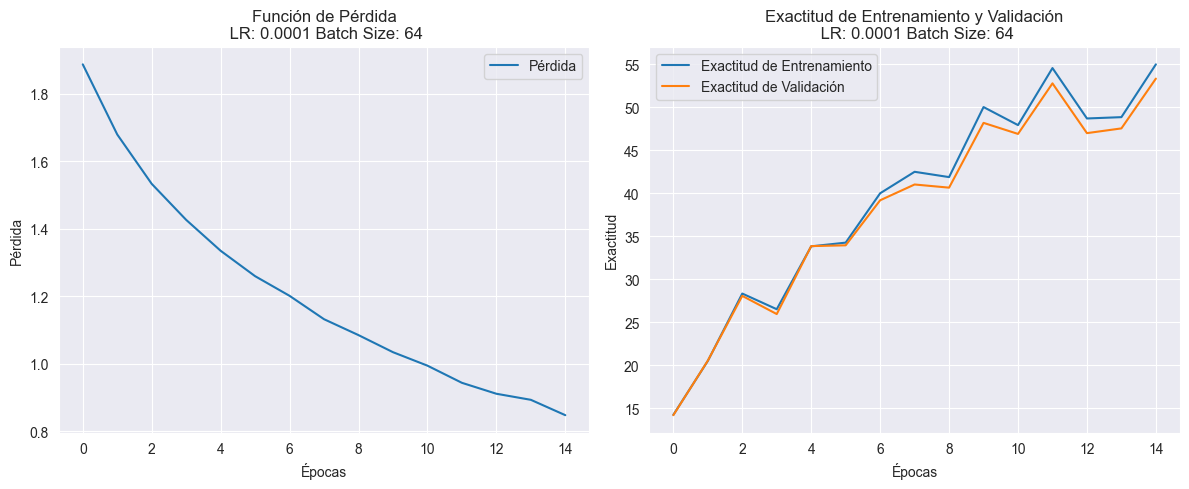


Entrenando con lr=0.0001, batch_size=64, epochs=30
    Época 1, pérdida: 1.8788, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
    Época 2, pérdida: 1.6474, exactitud entrenamiento: 14.54%, exactitud validación: 14.40%
    Época 3, pérdida: 1.5034, exactitud entrenamiento: 16.48%, exactitud validación: 15.96%
    Época 4, pérdida: 1.4018, exactitud entrenamiento: 22.12%, exactitud validación: 21.38%
    Época 5, pérdida: 1.3084, exactitud entrenamiento: 22.18%, exactitud validación: 21.74%
    Época 6, pérdida: 1.2417, exactitud entrenamiento: 33.15%, exactitud validación: 32.02%
    Época 7, pérdida: 1.1518, exactitud entrenamiento: 36.54%, exactitud validación: 33.67%
    Época 8, pérdida: 1.1013, exactitud entrenamiento: 43.31%, exactitud validación: 41.01%
    Época 9, pérdida: 1.0564, exactitud entrenamiento: 47.57%, exactitud validación: 44.77%
    Época 10, pérdida: 1.0075, exactitud entrenamiento: 47.04%, exactitud validación: 44.04%
    Época 11, pérdida: 0.97

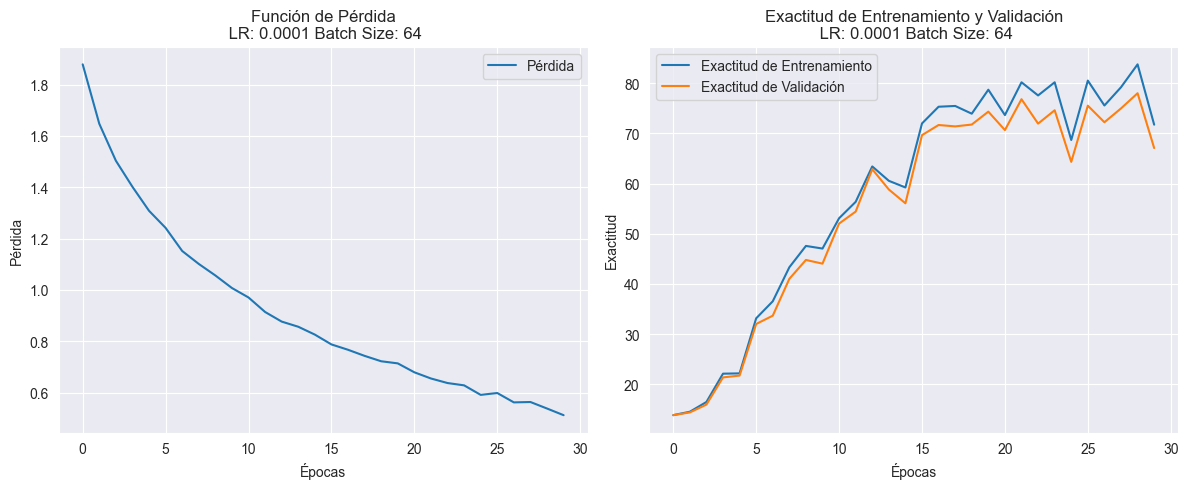


Entrenando con lr=5e-05, batch_size=32, epochs=15
    Época 1, pérdida: 1.9652, exactitud entrenamiento: 21.23%, exactitud validación: 21.93%
    Época 2, pérdida: 1.7576, exactitud entrenamiento: 27.20%, exactitud validación: 27.61%
    Época 3, pérdida: 1.6492, exactitud entrenamiento: 21.07%, exactitud validación: 19.72%
    Época 4, pérdida: 1.5493, exactitud entrenamiento: 20.36%, exactitud validación: 19.27%
    Época 5, pérdida: 1.4787, exactitud entrenamiento: 28.10%, exactitud validación: 27.98%
    Época 6, pérdida: 1.4252, exactitud entrenamiento: 30.41%, exactitud validación: 29.91%
    Época 7, pérdida: 1.3525, exactitud entrenamiento: 37.00%, exactitud validación: 35.32%
    Época 8, pérdida: 1.3199, exactitud entrenamiento: 39.77%, exactitud validación: 37.98%
    Época 9, pérdida: 1.2605, exactitud entrenamiento: 49.14%, exactitud validación: 46.24%
    Época 10, pérdida: 1.1963, exactitud entrenamiento: 42.30%, exactitud validación: 40.64%
    Época 11, pérdida: 1.168

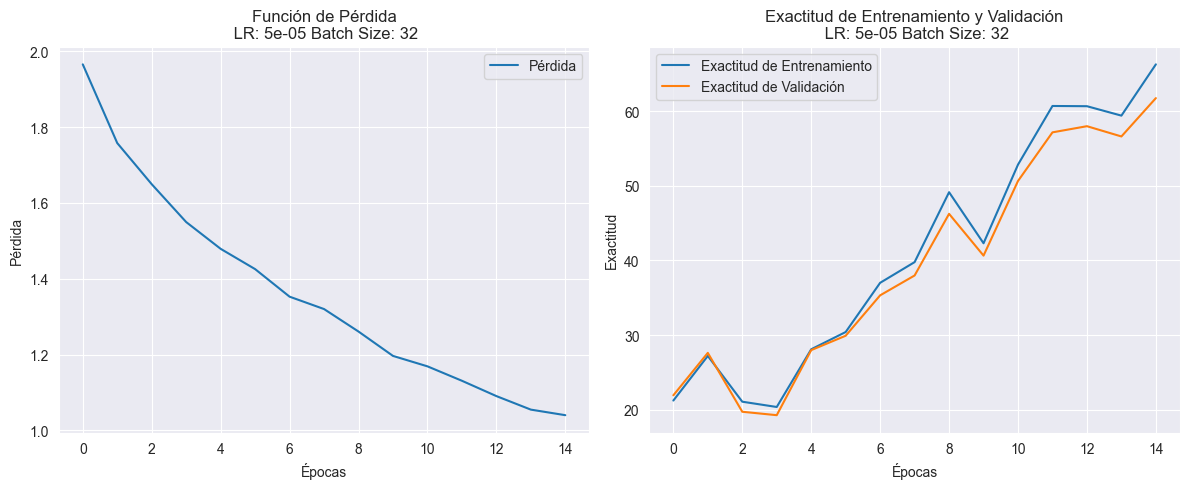


Entrenando con lr=5e-05, batch_size=32, epochs=30
    Época 1, pérdida: 1.9018, exactitud entrenamiento: 16.51%, exactitud validación: 15.87%
    Época 2, pérdida: 1.7275, exactitud entrenamiento: 16.57%, exactitud validación: 15.96%
    Época 3, pérdida: 1.6248, exactitud entrenamiento: 20.39%, exactitud validación: 19.91%
    Época 4, pérdida: 1.5433, exactitud entrenamiento: 27.91%, exactitud validación: 28.07%
    Época 5, pérdida: 1.4731, exactitud entrenamiento: 32.69%, exactitud validación: 32.48%
    Época 6, pérdida: 1.4024, exactitud entrenamiento: 30.90%, exactitud validación: 30.55%
    Época 7, pérdida: 1.3483, exactitud entrenamiento: 35.18%, exactitud validación: 34.95%
    Época 8, pérdida: 1.3040, exactitud entrenamiento: 36.08%, exactitud validación: 35.87%
    Época 9, pérdida: 1.2437, exactitud entrenamiento: 38.45%, exactitud validación: 36.70%
    Época 10, pérdida: 1.1936, exactitud entrenamiento: 42.64%, exactitud validación: 41.01%
    Época 11, pérdida: 1.153

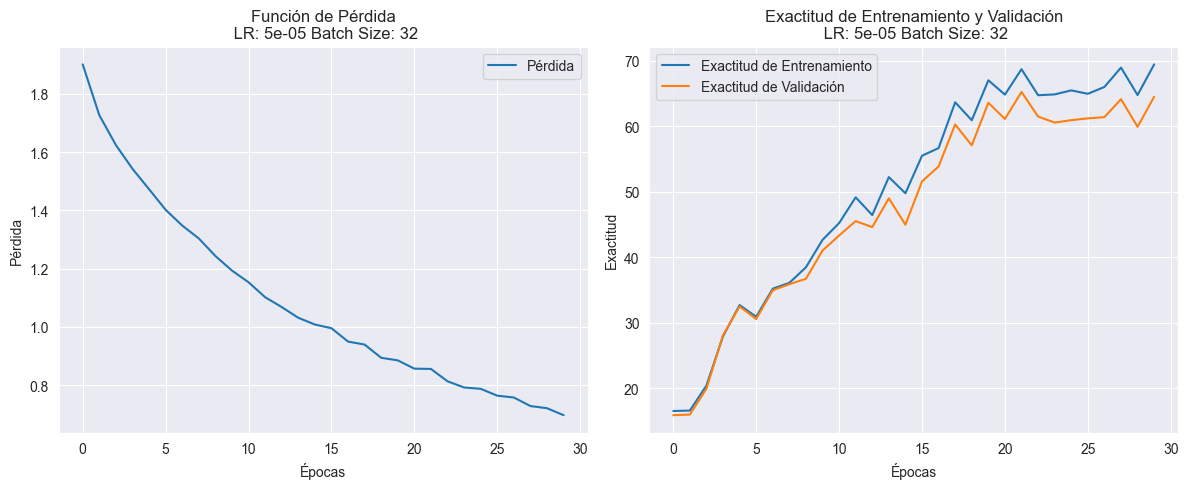


Entrenando con lr=5e-05, batch_size=64, epochs=15
    Época 1, pérdida: 1.9615, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
    Época 2, pérdida: 1.7806, exactitud entrenamiento: 14.05%, exactitud validación: 14.40%
    Época 3, pérdida: 1.6857, exactitud entrenamiento: 14.14%, exactitud validación: 14.22%
    Época 4, pérdida: 1.6074, exactitud entrenamiento: 15.65%, exactitud validación: 15.23%
    Época 5, pérdida: 1.5422, exactitud entrenamiento: 16.51%, exactitud validación: 15.87%
    Época 6, pérdida: 1.5008, exactitud entrenamiento: 17.28%, exactitud validación: 17.06%
    Época 7, pérdida: 1.4381, exactitud entrenamiento: 20.39%, exactitud validación: 21.10%
    Época 8, pérdida: 1.3924, exactitud entrenamiento: 24.25%, exactitud validación: 25.41%
    Época 9, pérdida: 1.3501, exactitud entrenamiento: 25.20%, exactitud validación: 25.41%
    Época 10, pérdida: 1.2855, exactitud entrenamiento: 30.13%, exactitud validación: 30.28%
    Época 11, pérdida: 1.274

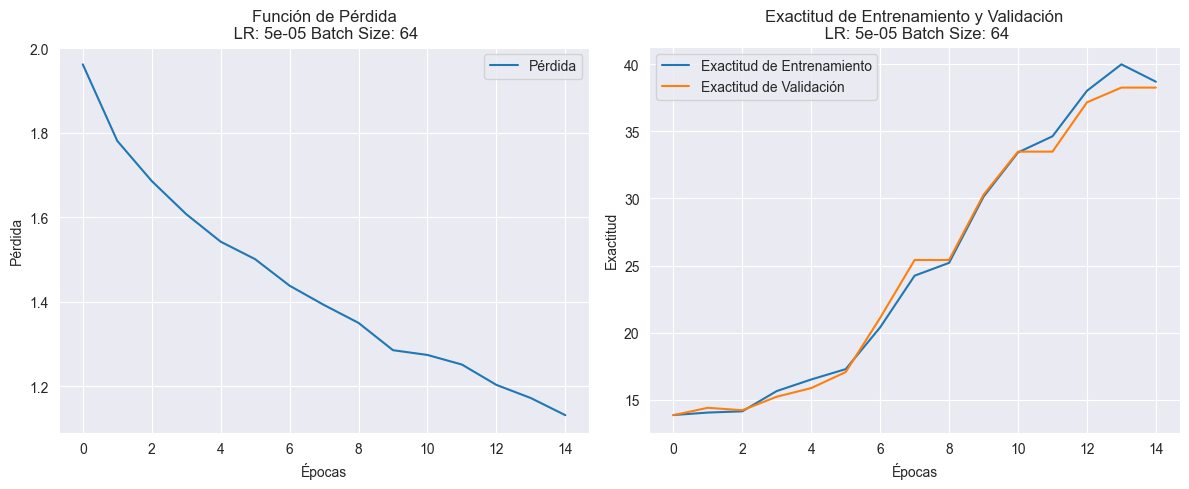


Entrenando con lr=5e-05, batch_size=64, epochs=30
    Época 1, pérdida: 1.9350, exactitud entrenamiento: 13.92%, exactitud validación: 13.94%
    Época 2, pérdida: 1.7665, exactitud entrenamiento: 14.23%, exactitud validación: 14.04%
    Época 3, pérdida: 1.6946, exactitud entrenamiento: 14.26%, exactitud validación: 14.13%
    Época 4, pérdida: 1.6194, exactitud entrenamiento: 14.36%, exactitud validación: 14.04%
    Época 5, pérdida: 1.5587, exactitud entrenamiento: 15.31%, exactitud validación: 14.95%
    Época 6, pérdida: 1.5055, exactitud entrenamiento: 17.31%, exactitud validación: 16.70%
    Época 7, pérdida: 1.4392, exactitud entrenamiento: 18.24%, exactitud validación: 17.80%
    Época 8, pérdida: 1.4058, exactitud entrenamiento: 19.99%, exactitud validación: 20.00%
    Época 9, pérdida: 1.3446, exactitud entrenamiento: 21.35%, exactitud validación: 21.01%
    Época 10, pérdida: 1.3044, exactitud entrenamiento: 20.64%, exactitud validación: 20.73%
    Época 11, pérdida: 1.270

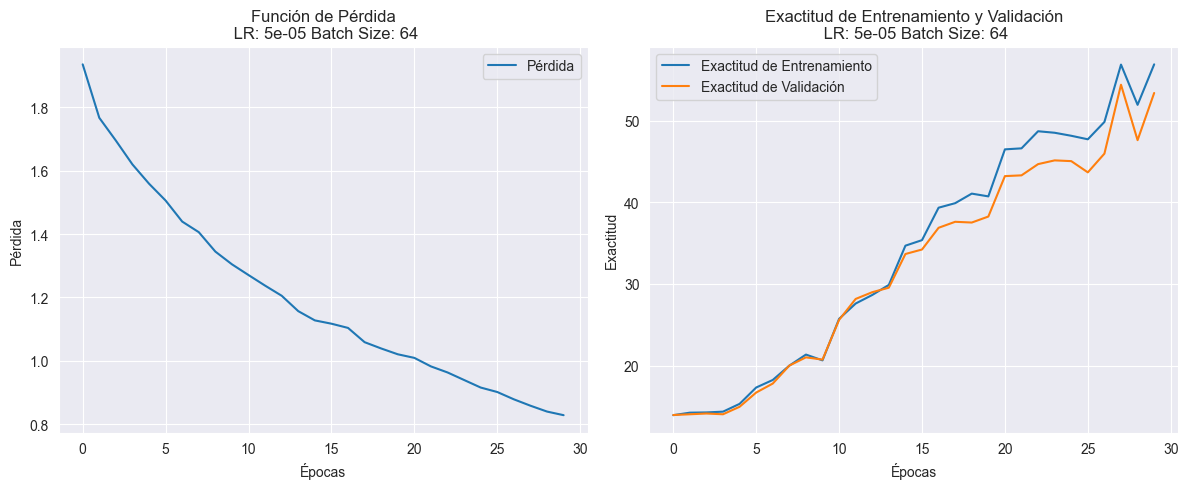


Entrenando con lr=1e-05, batch_size=32, epochs=15
    Época 1, pérdida: 2.0444, exactitud entrenamiento: 14.36%, exactitud validación: 14.95%
    Época 2, pérdida: 1.9923, exactitud entrenamiento: 15.28%, exactitud validación: 15.32%
    Época 3, pérdida: 1.9340, exactitud entrenamiento: 17.56%, exactitud validación: 18.62%
    Época 4, pérdida: 1.9055, exactitud entrenamiento: 15.99%, exactitud validación: 15.87%
    Época 5, pérdida: 1.8512, exactitud entrenamiento: 17.56%, exactitud validación: 17.89%
    Época 6, pérdida: 1.8100, exactitud entrenamiento: 18.11%, exactitud validación: 18.90%
    Época 7, pérdida: 1.7837, exactitud entrenamiento: 16.73%, exactitud validación: 16.88%
    Época 8, pérdida: 1.7636, exactitud entrenamiento: 15.87%, exactitud validación: 15.78%
    Época 9, pérdida: 1.7423, exactitud entrenamiento: 16.94%, exactitud validación: 16.79%
    Época 10, pérdida: 1.7213, exactitud entrenamiento: 16.73%, exactitud validación: 16.79%
    Época 11, pérdida: 1.687

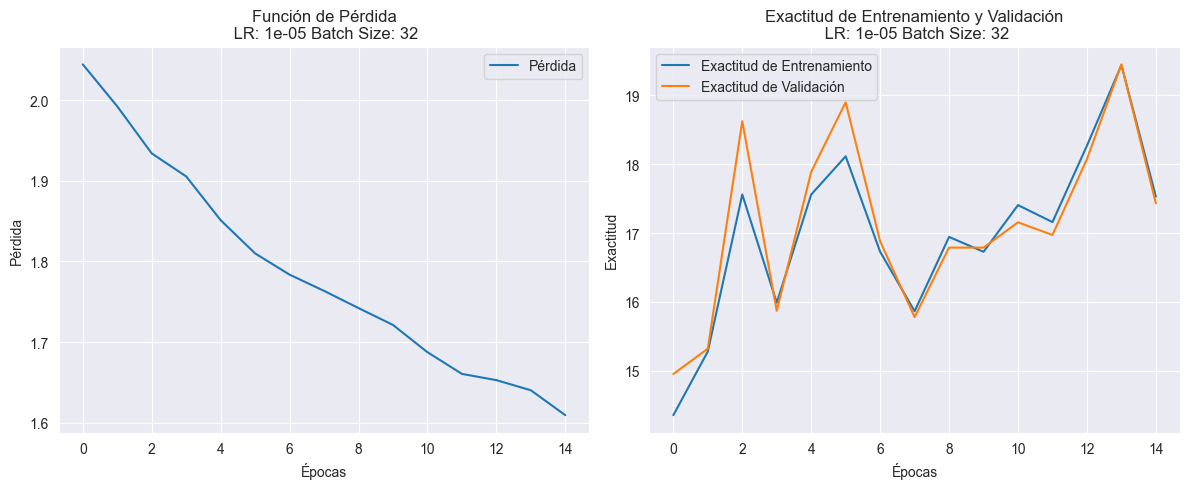


Entrenando con lr=1e-05, batch_size=32, epochs=30
    Época 1, pérdida: 2.0442, exactitud entrenamiento: 14.08%, exactitud validación: 14.04%
    Época 2, pérdida: 1.9580, exactitud entrenamiento: 14.33%, exactitud validación: 14.04%
    Época 3, pérdida: 1.9100, exactitud entrenamiento: 15.19%, exactitud validación: 14.50%
    Época 4, pérdida: 1.8399, exactitud entrenamiento: 21.60%, exactitud validación: 20.28%
    Época 5, pérdida: 1.8300, exactitud entrenamiento: 16.73%, exactitud validación: 15.60%
    Época 6, pérdida: 1.7776, exactitud entrenamiento: 16.79%, exactitud validación: 15.60%
    Época 7, pérdida: 1.7526, exactitud entrenamiento: 16.91%, exactitud validación: 15.87%
    Época 8, pérdida: 1.7188, exactitud entrenamiento: 18.88%, exactitud validación: 18.07%
    Época 9, pérdida: 1.7006, exactitud entrenamiento: 17.81%, exactitud validación: 17.25%
    Época 10, pérdida: 1.6694, exactitud entrenamiento: 18.48%, exactitud validación: 17.98%
    Época 11, pérdida: 1.641

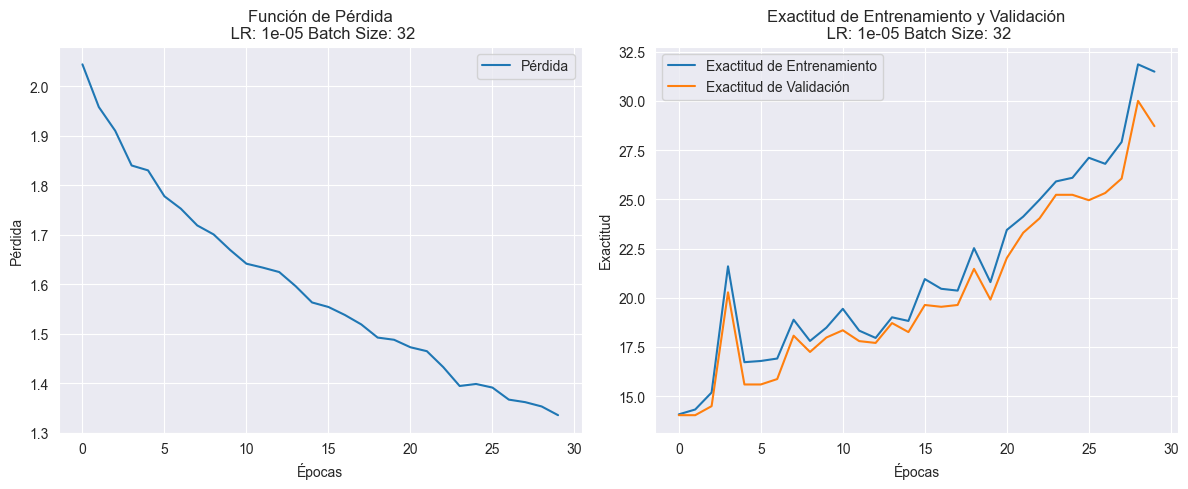


Entrenando con lr=1e-05, batch_size=64, epochs=15
    Época 1, pérdida: 2.0326, exactitud entrenamiento: 16.02%, exactitud validación: 16.33%
    Época 2, pérdida: 2.0004, exactitud entrenamiento: 19.78%, exactitud validación: 21.19%
    Época 3, pérdida: 1.9431, exactitud entrenamiento: 15.28%, exactitud validación: 15.23%
    Época 4, pérdida: 1.8994, exactitud entrenamiento: 14.39%, exactitud validación: 14.04%
    Época 5, pérdida: 1.8473, exactitud entrenamiento: 14.17%, exactitud validación: 13.94%
    Época 6, pérdida: 1.8323, exactitud entrenamiento: 14.08%, exactitud validación: 13.94%
    Época 7, pérdida: 1.7934, exactitud entrenamiento: 14.05%, exactitud validación: 13.94%
    Época 8, pérdida: 1.7780, exactitud entrenamiento: 14.20%, exactitud validación: 13.94%
    Época 9, pérdida: 1.7559, exactitud entrenamiento: 14.02%, exactitud validación: 13.94%
    Época 10, pérdida: 1.7403, exactitud entrenamiento: 14.11%, exactitud validación: 13.94%
    Época 11, pérdida: 1.712

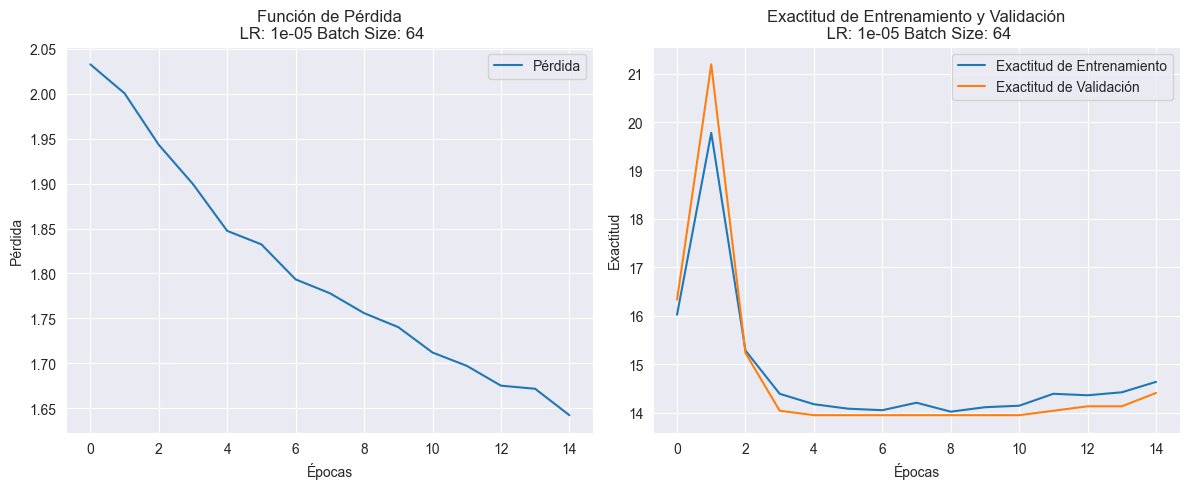


Entrenando con lr=1e-05, batch_size=64, epochs=30
    Época 1, pérdida: 2.0294, exactitud entrenamiento: 13.86%, exactitud validación: 13.94%
    Época 2, pérdida: 1.9559, exactitud entrenamiento: 14.91%, exactitud validación: 14.22%
    Época 3, pérdida: 1.9124, exactitud entrenamiento: 14.60%, exactitud validación: 14.40%
    Época 4, pérdida: 1.8604, exactitud entrenamiento: 14.29%, exactitud validación: 14.13%
    Época 5, pérdida: 1.8099, exactitud entrenamiento: 14.20%, exactitud validación: 13.94%
    Época 6, pérdida: 1.7869, exactitud entrenamiento: 14.20%, exactitud validación: 14.04%
    Época 7, pérdida: 1.7720, exactitud entrenamiento: 14.26%, exactitud validación: 13.94%
    Época 8, pérdida: 1.7252, exactitud entrenamiento: 14.20%, exactitud validación: 13.94%
    Época 9, pérdida: 1.6967, exactitud entrenamiento: 14.11%, exactitud validación: 13.94%
    Época 10, pérdida: 1.6580, exactitud entrenamiento: 14.20%, exactitud validación: 13.94%
    Época 11, pérdida: 1.682

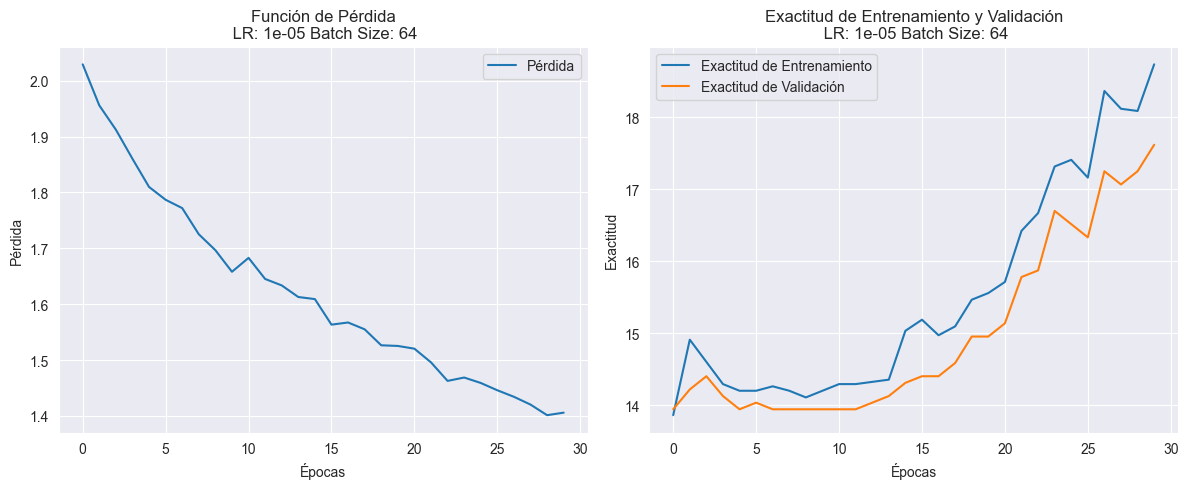

In [7]:
import torch.optim as optim
from itertools import product

learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
batch_sizes = [32, 64]
epochs_list = [15, 30]

resultados = []
modelos = {}

for lr, batch_size, epochs in product(learning_rates, batch_sizes, epochs_list):

    # Crear DataLoaders para los datos de entrenamiento, validación y test
    dataloader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=batch_size, shuffle=True)
    dataloader_validacion = DataLoader(dataset_validacion, batch_size=batch_size, shuffle=False)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    modelo = ConvNet().to(device)
    criterio = nn.CrossEntropyLoss()
    optimizador = optim.Adam(modelo.parameters(), lr=lr)

    combinacion = (lr, batch_size, epochs)
    print(f"\nEntrenando con lr={lr}, batch_size={batch_size}, epochs={epochs}")

    modelos[combinacion] = modelo

    valores_perdida = []
    exactitud_entrenamiento = []
    exactitud_validacion = []

    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoca in range(epochs):
        modelos[combinacion].train()
        running_loss = 0.0
        for images, labels in dataloader_entrenamiento:
            images, labels = images.to(device), labels.to(device)
            outputs = modelos[combinacion](images)
            loss = criterio(outputs, labels)
            loss.backward()
            optimizador.step()
            optimizador.zero_grad()
            running_loss += loss.item()

        valores_perdida.append(running_loss / len(dataloader_entrenamiento))

        with torch.no_grad():
            modelos[combinacion].eval()

            # Calcular exactitud de entrenamiento
            correctas = 0
            total = 0
            for images, labels in dataloader_entrenamiento:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_entrenamiento.append(100 * correctas / total)

            # Calcular exactitud de validación
            correctas = 0
            total = 0
            for images, labels in dataloader_validacion:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_validacion.append(100 * correctas / total)

        # Early stopping
        val_loss = valores_perdida[-1]  # Usamos la pérdida más reciente
        early_stopping(val_loss, modelo)

        # Verifica si se activa la parada anticipada
        if early_stopping.early_stop:
            print("Parada anticipada activada")
            modelo.load_state_dict(early_stopping.best_model_wts)  # Cargar los mejores pesos
            break

        # Imprimir métricas de la época
        print(f'    Época {epoca+1}, pérdida: {val_loss:.4f}, exactitud entrenamiento: {exactitud_entrenamiento[-1]:.2f}%, exactitud validación: {exactitud_validacion[-1]:.2f}%')

    graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion)
    resultados.append((lr, batch_size, epochs, exactitud_validacion[-1]))


Top configuraciones:
    LR=0.001, Batch=64, Epochs=30, Exactitud validación=86.33%
    LR=0.005, Batch=32, Epochs=30, Exactitud validación=86.24%
    LR=0.001, Batch=32, Epochs=30, Exactitud validación=85.69%
    LR=0.0005, Batch=64, Epochs=30, Exactitud validación=85.69%
    LR=0.001, Batch=64, Epochs=15, Exactitud validación=84.50%

Exactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR=0.001, Batch=64, Epochs=30    : 83.77%
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8926    0.7248    0.8000       149
           1     0.9474    0.9474    0.9474       152
           2     0.9048    0.7651    0.8291       149
           3     0.8662    0.7861    0.8242       173
           4     0.8282    0.9000    0.8626       150
           5     0.7134    0.7852    0.7476       149
           6     0.7641    0.9551    0.8490       156

    accuracy                         0.8377      1078
   macro avg     0.8452    

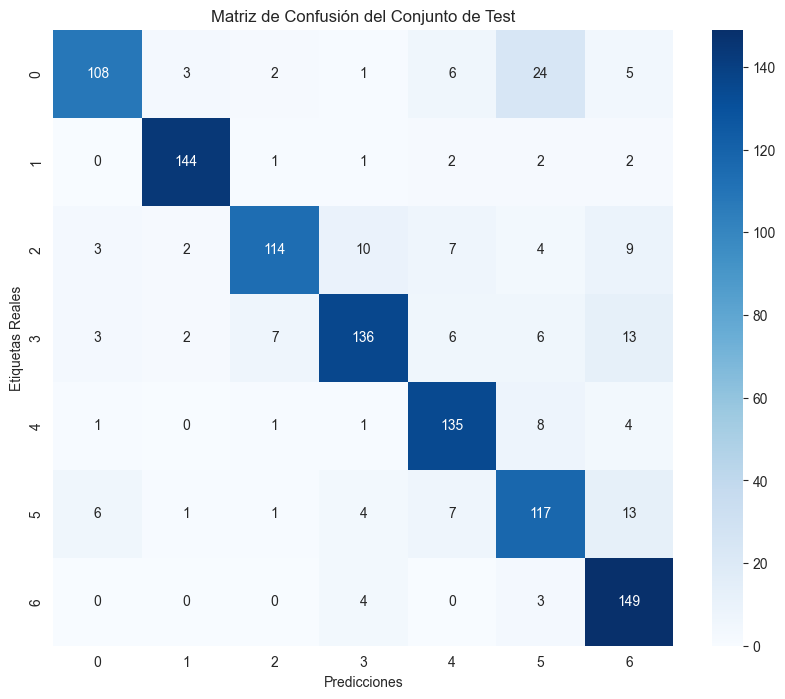

Clases presentes en el conjunto de test: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)}


In [8]:
mejores_resultados = sorted(resultados, key=lambda x: x[3], reverse=True)
print("Top configuraciones:")
for res in mejores_resultados[:5]:
    print(f"    LR={res[0]}, Batch={res[1]}, Epochs={res[2]}, Exactitud validación={res[3]:.2f}%")

mejor = (mejores_resultados[0][0], mejores_resultados[0][1], mejores_resultados[0][2])
modelo = modelos[mejor]
exactitud_test = calcular_exactitud_test(modelo, dataloader_test, device)
print(f"\nExactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR={mejor[0]}, Batch={mejor[1]}, Epochs={mejor[2]}    : {exactitud_test:.2f}%")
matriz_de_confusion(modelo, dataloader_test, device)